In [1]:
from requests import get

#get the first page of the east bay housing prices
response = get('https://sfbay.craigslist.org/search/sfc/reb?hasPic=1&search_distance=5&postal=94114&availabilityMode=0&housing_type=1&housing_type=2&housing_type=3&housing_type=4&housing_type=6&housing_type=9&sale_date=all+dates') #get rid of those lame-o's that post a housing option without a pic using their filter

from bs4 import BeautifulSoup
html_soup = BeautifulSoup(response.text, 'html.parser')

#get the macro-container for the housing posts
posts = html_soup.find_all('li', class_= 'result-row')


from time import sleep
import re
from random import randint #avoid throttling by not sending too many requests one after the other
from warnings import warn
from time import time
from IPython.core.display import clear_output
import numpy as np

#find the total number of posts to find the limit of the pagination
results_num = html_soup.find('div', class_= 'search-legend')
results_total = int(results_num.find('span', class_='totalcount').text) #pulled the total count of posts as the upper bound of the pages array

#each page has 119 posts so each new page is defined as follows: s=120, s=240, s=360, and so on. So we need to step in size 120 in the np.arange function
pages = np.arange(0, results_total+1)

iterations = 0

post_timing = []
post_hoods = []
post_title_texts = []
bedroom_counts = []
sqfts = []
post_links = []
post_prices = []

for post in posts:

    if post.find('span', class_ = 'result-hood') is not None:

        #posting date
        #grab the datetime element 0 for date and 1 for time
        post_datetime = post.find('time', class_= 'result-date')['datetime']
        post_timing.append(post_datetime)

        #neighborhoods
        post_hood = post.find('span', class_= 'result-hood').text
        post_hood=re.split(r'[\(\)]',post_hood)
        post_hood=''.join(post_hood)
        post_hoods.append(post_hood)
        

        #title text
        post_title = post.find('a', class_='result-title hdrlnk')
        post_title_text = post_title.text
        post_title_texts.append(post_title_text)

        #post link
        post_link = post_title['href']
        post_links.append(post_link)
            
        #removes the \n whitespace from each side, removes the currency symbol, and turns it into an int
        post_price = int(post.a.text.strip().replace("$", "")) 
        post_prices.append(post_price)
            
        if post.find('span', class_ = 'housing') is None:
            bedroom_count = np.nan
            bedroom_counts.append(bedroom_count)
            sqft=np.nan
            sqfts.append(sqft)
                
        #if the first element is accidentally square footage
        elif 'ft2' in post.find('span', class_ = 'housing').text.split()[0]:

            #make bedroom nan
            bedroom_count = np.nan
            bedroom_counts.append(bedroom_count)

            #make sqft the first element
            sqft = int(post.find('span', class_ = 'housing').text.split()[0][:-3])
            sqfts.append(sqft)

            #if the length of the housing details element is more than 2
        elif len(post.find('span', class_ = 'housing').text.split()) > 2:

            #therefore element 0 will be bedroom count
            bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
            bedroom_counts.append(bedroom_count)

            #and sqft will be number 3, so set these here and append
            sqft = int(post.find('span', class_ = 'housing').text.split()[2][:-3])
            sqfts.append(sqft)

            #if there is num bedrooms but no sqft
        elif len(post.find('span', class_ = 'housing').text.split()) == 2:

            #therefore element 0 will be bedroom count
            bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
            bedroom_counts.append(bedroom_count)

            #and sqft will be number 3, so set these here and append
            sqft = np.nan
            sqfts.append(sqft)                    

        else:
            bedroom_count = np.nan
            bedroom_counts.append(bedroom_count)

            sqft = np.nan
            sqfts.append(sqft)

        #if none of those conditions catch, make bedroom nan, this won't be needed    

import pandas as pd

craigslist_options = pd.DataFrame({'posted': post_timing,
                       'neighborhood': post_hoods,
                       'post title': post_title_texts,
                       'number bedrooms': bedroom_counts,
                        'sqft': sqfts,
                        'URL': post_links,
                       'price': post_prices})

In [2]:
Latitude=[]
Longitude=[]
Picture=[]
for i in range(0,len(craigslist_options.iloc[:,2])):
    page_link=get(craigslist_options.iloc[i,5])
    page_link_soup=BeautifulSoup(page_link.text,'html.parser')
    FrontPic=page_link_soup.find('div',class_='slide first visible')
    for link in FrontPic.find_all('img'):
        FrontPic1=link.get('src')
    Picture.append(FrontPic1)
    MapPic=page_link_soup.find('div',id='map')
    MapPicLat=MapPic['data-latitude']
    MapPicLon=MapPic['data-longitude']
    Latitude.append(MapPicLat)
    Longitude.append(MapPicLon)

craigslist_options['Latitude']=Latitude
craigslist_options['Longitude']=Longitude
craigslist_options['Picture Link']=Picture
craigslist_options.head()

,posted,neighborhood,post title,number bedrooms,sqft,URL,price,Latitude,Longitude,Picture Link
0,2020-04-22 15:03,mission district,Treat Street 4 Bedroom 2 Bathroom,4,1250.0,https://sfbay.craigslist.org/sfc/reb/d/san-fra...,1399000,37.758700,-122.433000,https://images.craigslist.org/00B0B_3qHgjjC1UI...
1,2020-04-21 16:02,noe valley,Commercial condo for sale,NaN,720.0,https://sfbay.craigslist.org/sfc/reb/d/san-fra...,700000,37.751199,-122.435623,https://images.craigslist.org/00z0z_1fuzQiQpqR...
2,2020-04-21 21:37,castro / upper market,Fabulous 2 unit in Upper Castro,8,3832.0,https://sfbay.craigslist.org/sfc/reb/d/san-fra...,3265000,37.763265,-122.442534,https://images.craigslist.org/01717_hDr1DmN7iw...
3,2020-04-25 13:55,lower haight,>>107 Germania St / 2BR *Newly Renovated Kitch...,2,NaN,https://sfbay.craigslist.org/sfc/reb/d/san-fra...,4395,37.770696,-122.430268,https://images.craigslist.org/00I0I_cMDCm2H160...
4,2020-04-22 14:20,mission district,Well maintained office building for sale!,NaN,30000.0,https://sfbay.craigslist.org/sfc/reb/d/san-fra...,13500000,37.764057,-122.418680,https://images.craigslist.org/00B0B_agTyaKYbYk...


In [3]:
def decimalyear(stringdate):
    import datetime as dt
    from PyAstronomy import pyasl
    year=int(stringdate[0:4])
    month=int(stringdate[5:7])
    day=int(stringdate[8:10])
    hour=int(stringdate[11:13])
    minute=int(stringdate[14:])
    d=dt.datetime(year,month,day,hour,minute)
    dyear=pyasl.decimalYear(d)  
    return dyear

def datefromdec(dyear):
    from PyAstronomy import pyasl
    return pyasl.decimalYearGregorianDate(dyear,"yyyy-mm-dd hh:mm")

def fiveyears():
    import datetime as dt
    td=dt.date.today()
    tdtuple=td.timetuple()
    yr=tdtuple[0]+5
    fytuple=(yr,tdtuple[1],tdtuple[2])
    fy=dt.datetime(yr,tdtuple[1],tdtuple[2])
    return fy

def today_():
    import datetime as dt
    td=dt.date.today()
    tdtuple=td.timetuple()
    return td

In [4]:
import pandas as pd
import pickle
import numpy as np
from PyAstronomy import pyasl
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

craigslist_options_df=craigslist_options
RealEstateModel=pickle.load(open('value_model.sav','rb'))
postdec=[]
craigslist_options_df=craigslist_options_df[craigslist_options_df['neighborhood'] !=' daly city']
for i in np.array(craigslist_options_df['posted']):
    postdec.append(decimalyear(i))

postdec
NormPredict=[]
for i in postdec:
     NormPredict.append(RealEstateModel.predict(np.array(i).reshape(-1,1)))

NormPredict=list(map(float, NormPredict))
NormPredict
fypredict=float(RealEstateModel.predict(np.array(pyasl.decimalYear(fiveyears())).reshape(-1,1)))
print(type(fypredict))#fypredict=map(float, fypredict)

d=NormPredict*craigslist_options_df['sqft']
craigslist_options_df["Current Price Prediction"]=d
craigslist_options_df['Percent Difference']=2*(np.absolute(craigslist_options_df["Current Price Prediction"]-craigslist_options_df['price'])/(craigslist_options_df['Current Price Prediction']+craigslist_options_df['price']))
craigslist_options_df['Five Years Date']=pyasl.decimalYear(fiveyears())
craigslist_options_df['Five Years Prediction']=fypredict*craigslist_options_df['sqft']*(1-craigslist_options_df['Percent Difference'])

<class 'float'>


In [5]:
lat= craigslist_options_df['Latitude'].astype(str)
long=craigslist_options_df['Longitude'].astype(str)
coordinates=lat.str.cat(long,sep=', ')

In [6]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="ModelApplications")
from geopy.extra.rate_limiter import RateLimiter
geocode = RateLimiter(geolocator.reverse, min_delay_seconds=1)
location=[]
for i in coordinates:
    location.append(geolocator.reverse(i,exactly_one=True))

#location = coordinates.apply(geocode)

#reverse(query, exactly_one=True, timeout=DEFAULT_SENTINEL, language=False, addressdetails=True)

In [7]:

addressList = []
for i in location:
    addressArray=i.address.split(',')
    if not addressArray[0].isnumeric():
        addressArray.pop(0)
    addressList.append(','.join(addressArray[0:4]))
craigslist_options_df['Address']=addressList

In [8]:
craigslist_options_df

,posted,neighborhood,post title,number bedrooms,sqft,URL,price,Latitude,Longitude,Picture Link,Current Price Prediction,Percent Difference,Five Years Date,Five Years Prediction,Address
0,2020-04-22 15:03,mission district,Treat Street 4 Bedroom 2 Bathroom,4,1250.0,https://sfbay.craigslist.org/sfc/reb/d/san-fra...,1399000,37.758700,-122.433000,https://images.craigslist.org/00B0B_3qHgjjC1UI...,7.089380e+05,0.654727,2025.317808,3.255568e+05,"666, Noe Street, Castro District, San Francisco"
1,2020-04-21 16:02,noe valley,Commercial condo for sale,NaN,720.0,https://sfbay.craigslist.org/sfc/reb/d/san-fra...,700000,37.751199,-122.435623,https://images.craigslist.org/00z0z_1fuzQiQpqR...,4.082778e+05,0.526442,2025.317808,2.571933e+05,"4166, 24th Street, Noe Valley, San Francisco"
2,2020-04-21 21:37,castro / upper market,Fabulous 2 unit in Upper Castro,8,3832.0,https://sfbay.craigslist.org/sfc/reb/d/san-fra...,3265000,37.763265,-122.442534,https://images.craigslist.org/01717_hDr1DmN7iw...,2.173036e+06,0.401602,2025.317808,1.729696e+06,"145, Lower Terrace, Cole Valley, San Francisco"
3,2020-04-25 13:55,lower haight,>>107 Germania St / 2BR *Newly Renovated Kitch...,2,NaN,https://sfbay.craigslist.org/sfc/reb/d/san-fra...,4395,37.770696,-122.430268,https://images.craigslist.org/00I0I_cMDCm2H160...,NaN,NaN,2025.317808,NaN,"165, Germania Street, Western Addition, San Fr..."
4,2020-04-22 14:20,mission district,Well maintained office building for sale!,NaN,30000.0,https://sfbay.craigslist.org/sfc/reb/d/san-fra...,13500000,37.764057,-122.418680,https://images.craigslist.org/00B0B_agTyaKYbYk...,1.701442e+07,0.230345,2025.317808,1.741693e+07,"160, Capp Street, Mission District, San Franc..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,2020-04-24 10:13,San Francisco,investment opportunity,1,12200.0,https://sfbay.craigslist.org/sby/reb/d/san-fra...,11,37.721100,-122.475400,https://images.craigslist.org/00M0M_43j7RdpXWt...,6.921474e+06,1.999994,2025.317808,-9.202617e+06,"19th Avenue, Saint Francis Wood, San Francisc..."
76,2020-04-26 10:15,north beach / telegraph hill,3D TOUR! Exceptional Waterfront Living w Breat...,2,1532.0,https://sfbay.craigslist.org/sfc/reb/d/san-fra...,1888400,37.803901,-122.404132,https://images.craigslist.org/00000_1GO2vrH1sU...,8.694686e+05,0.738927,2025.317808,3.017001e+05,"101, Lombard Street, Telegraph Hill, San Franc..."
77,2020-04-23 13:20,north beach / telegraph hill,Loft Condo for Sale,1,NaN,https://sfbay.craigslist.org/sfc/reb/d/san-fra...,899000,37.804031,-122.403322,https://images.craigslist.org/00z0z_8u4JY9AuTZ...,NaN,NaN,2025.317808,NaN,"Lombard Street, Telegraph Hill, San Francisco..."
78,2020-04-24 08:43,"Revelstoke, BC",Contemporary Home on Lakefront Acreage,4,NaN,https://sfbay.craigslist.org/sby/reb/d/daly-ci...,680000,37.705800,-122.461900,https://images.craigslist.org/00A0A_9swsx21Zd9...,NaN,NaN,2025.317808,NaN,"3, Hillcrest Drive, Daly City, San Mateo County"


In [9]:
hoods=pd.unique(craigslist_options_df['neighborhood'])
thoods=[]
for i in hoods:
    thoods.append((i,i))

minprice=craigslist_options_df['price'].min()
maxprice=craigslist_options_df['price'].max()
priceoptions=np.linspace(maxprice,minprice,5,endpoint=False,dtype=int)
tpriceoptions=[]
for i in priceoptions:
    tpriceoptions.append((str(i),str(i)))
tpriceoptions


[('13500000', '13500000'),
 ('10800000', '10800000'),
 ('8100000', '8100000'),
 ('5400000', '5400000'),
 ('2700000', '2700000')]

In [10]:
from flask_wtf import FlaskForm
from wtforms import StringField, SubmitField, TextField, HiddenField, FieldList, FormField, SelectField, SelectMultipleField
from wtforms.validators import InputRequired, NoneOf

Neighborhoods = thoods
Prices = tpriceoptions
class PageManager():
    def __init__(self):
        #inits here
        self.defaultPrice = None
        self.defaultNeighborhood = None
        self.topPicks = None
    def init(self, dataframe=None):
        #get a list neighborhoods
        
        self.form = EntryForm()
        
    def update(self, request, dataframe=None):
        #update Form choices
        self.defaultPrice = request.form.getlist('MaxPriceDropdown')[0]
        self.form.MaxPriceDropdown.data = self.defaultPrice
        self.defaultNeighborhood = request.form.getlist('NeighborhoodsDropdown')
        self.form.NeighborhoodsDropdown.data = self.defaultNeighborhood
        
        print(self.defaultPrice)
        print(self.defaultNeighborhood)
        
        #filter dataframe given selections
        if self.defaultPrice is not None:
            filterprice=craigslist_options_df['price']<=int(self.defaultPrice)
            crfilter_df=craigslist_options_df[filterprice]
        else:
            crfilter_df=craigslist_options_df
        if len(self.defaultNeighborhood)>0:
            filterhoods=craigslist_options_df['neighborhood'].isin(self.defaultNeighborhood)
            crfilter_df2=crfilter_df[filterhoods]
        else:
            crfilter_df2=crfilter_df

        top_picks = crfilter_df2.sort_values(['Five Years Prediction'], ascending=False,na_position='last').head()#filter soehow
        
        self.topPicks = top_picks

        
        

class EntryForm(FlaskForm):
    MaxPriceDropdown = SelectField("Pick Price", choices = Prices, validators=[InputRequired()])
    NeighborhoodsDropdown = SelectMultipleField("Pick Location", choices = Neighborhoods, validators=[InputRequired()])







In [11]:
from flask import Flask, render_template, request, redirect
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
app = Flask(__name__)
app.config['SECRET_KEY'] = "SecretKey123"

pm = PageManager()
#outputCheck = None

@app.before_first_request
def initializeForm():
    global pm
    pm.init()
    
    
# prevent cached responses
@app.route('/',  methods=['GET','POST'])
def index():
    global pm
    form = pm.form
    return render_template('index.html', form=form)

@app.route('/Update',  methods=['GET','POST'])
def update():
    global pm
    
    pm.update(request)
      
    return redirect("/")

@app.route('/results',  methods=['GET','POST'])
def results():
    global pm, outputCheck
    outputCheck = pm.topPicks
    
    td=dt.date.today()
    tdtuple=td.timetuple()
    yr=tdtuple[0]+5
    fytuple=(yr,tdtuple[1],tdtuple[2])
    fy=dt.datetime(yr,tdtuple[1],tdtuple[2])
    zz=np.array([outputCheck.iloc[0,6],outputCheck.iloc[0,-2]])
    xx=np.array([td,fy])
    labels=['Listed Price','Expected Price']
    x=np.arange(len(labels))
    width=0.5
    y=[outputCheck.iloc[0,6],int(outputCheck.iloc[0,-5])]

    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
    ax2.plot(xx,zz)
    ax2.set(xlabel='Time (years)',ylabel='Value (dollars)',)
    ax2.set_title('Future Home Value')

    ax1.bar(x,y,width)
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels)
    ax1.set(ylabel='Value (dollars)',title='Listed Value vs Expected Value')
    fig.tight_layout(pad=5.0)
    fig.savefig('./static/images/plot.jpeg')
    plotimg = './static/images/plot.jpeg'
    message='Press [Ctrl]+[Shift]+[R] to clear the cache and display results!!'
    link=outputCheck.iloc[0,5]
    return render_template('results.html', img=plotimg, outputCheck=outputCheck, message=message, link=link)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [27/Apr/2020 00:07:43] "POST /Update HTTP/1.1" 302 -
127.0.0.1 - - [27/Apr/2020 00:07:43] "GET / HTTP/1.1" 200 -


10800000
[' glen park']


127.0.0.1 - - [27/Apr/2020 00:07:45] "POST /Update HTTP/1.1" 302 -
127.0.0.1 - - [27/Apr/2020 00:07:45] "GET / HTTP/1.1" 200 -


10800000
[' haight ashbury']


127.0.0.1 - - [27/Apr/2020 00:07:51] "POST /Update HTTP/1.1" 302 -
127.0.0.1 - - [27/Apr/2020 00:07:51] "GET / HTTP/1.1" 200 -


10800000
[' mission district']


127.0.0.1 - - [27/Apr/2020 00:07:53] "POST /Update HTTP/1.1" 302 -
127.0.0.1 - - [27/Apr/2020 00:07:53] "GET / HTTP/1.1" 200 -


10800000
[' mission district', ' noe valley']


127.0.0.1 - - [27/Apr/2020 00:07:54] "POST /Update HTTP/1.1" 302 -
127.0.0.1 - - [27/Apr/2020 00:07:54] "GET / HTTP/1.1" 200 -


10800000
[' mission district', ' noe valley', ' castro / upper market']


127.0.0.1 - - [27/Apr/2020 00:07:56] "GET /results HTTP/1.1" 200 -


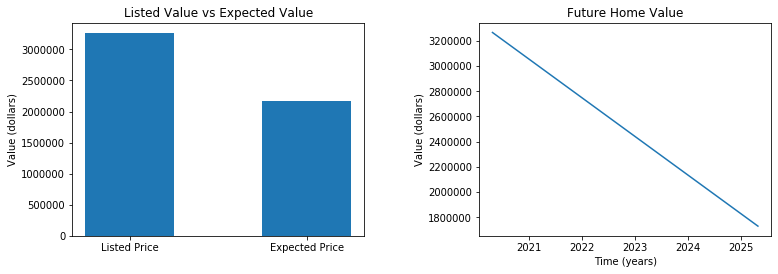

In [12]:
app.run()

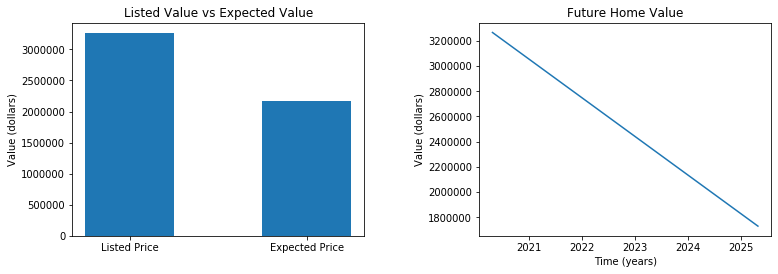

In [13]:
import datetime as dt
import numpy as np
td=dt.date.today()
tdtuple=td.timetuple()
yr=tdtuple[0]+5
fytuple=(yr,tdtuple[1],tdtuple[2])
fy=dt.datetime(yr,tdtuple[1],tdtuple[2])
zz=np.array([outputCheck.iloc[0,6],outputCheck.iloc[0,-2]])
xx=np.array([td,fy])
labels=['Listed Price','Expected Price']
x=np.arange(len(labels))
width=0.5
y=[outputCheck.iloc[0,6],int(outputCheck.iloc[0,-5])]

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
ax2.plot(xx,zz)
ax2.set(xlabel='Time (years)',ylabel='Value (dollars)',)
ax2.set_title('Future Home Value')

ax1.bar(x,y,width)
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.set(ylabel='Value (dollars)',title='Listed Value vs Expected Value')
fig.tight_layout(pad=5.0)